<a href="https://colab.research.google.com/github/ahmed-bouali/codeforces_problem_tagger/blob/main/sheet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CodeForces problems classification**
By Ahmed Bouali

### ENV SETUP

In [67]:
!unzip code_classification_dataset.zip
!pip install pytorch-lightning

Streaming output truncated to the last 5000 lines.
  inflating: code_classification_dataset/sample_94.json  
  inflating: code_classification_dataset/sample_96.json  
  inflating: code_classification_dataset/sample_108.json  
  inflating: code_classification_dataset/sample_109.json  
  inflating: code_classification_dataset/sample_115.json  
  inflating: code_classification_dataset/sample_119.json  
  inflating: code_classification_dataset/sample_121.json  
  inflating: code_classification_dataset/sample_125.json  
  inflating: code_classification_dataset/sample_126.json  
  inflating: code_classification_dataset/sample_131.json  
  inflating: code_classification_dataset/sample_134.json  
  inflating: code_classification_dataset/sample_139.json  
  inflating: code_classification_dataset/sample_143.json  
  inflating: code_classification_dataset/sample_150.json  
  inflating: code_classification_dataset/sample_152.json  
  inflating: code_classification_dataset/sample_160.json  
  infla

In [68]:
import json
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pytorch_lightning as pl
import torch


from time import sleep
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import MultiLabelBinarizer

from openai import AzureOpenAI

from torch import cuda, nn
from torch.utils.data import Dataset, DataLoader


from transformers import Trainer, TrainingArguments
from transformers import BertTokenizerFast, AutoTokenizer
from transformers import BertConfig, BertModel, get_linear_schedule_with_warmup

from torchmetrics.classification import MulticlassF1Score

In [69]:
os.environ["AZURE_OPENAI_API_KEY"] = "AZOAI KEY"
os.environ["AZURE_OPENAI_ENDPOINT"] = "AZOAI EP"

os.environ["OPENAI_API_TYPE"] = "azure"
os.environ["OPENAI_API_VERSION"] = "VERSION"

os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cpu


In [70]:
os.environ["AZURE_OPENAI_API_KEY"] = "YOUR AZOAI KEY"
os.environ["AZURE_OPENAI_ENDPOINT"] = "YOUR AZOIA ENDPOINT"

os.environ["OPENAI_API_TYPE"] = "azure"
os.environ["OPENAI_API_VERSION"] = "VERSION"

os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cpu


### DATA EXPLORING

In [71]:
directory_path = '/content/code_classification_dataset/'
all_files = os.listdir(directory_path)
json_files = [f for f in all_files if f.endswith('.json')]

In [72]:
all_data = []
for file_name in json_files:
  file_path = os.path.join(directory_path, file_name)
  with open(file_path, 'r') as f:
    data = json.load(f)
    all_data.append(data)

In [73]:
#Lets see what a codeforces problem data sample looks like
all_data[1]

{'prob_desc_time_limit': '2 seconds',
 'prob_desc_sample_outputs': '["4427477", "4478"]',
 'src_uid': '8ce1ba0a98031c1bc28f53c11905391c',
 'prob_desc_notes': 'NoteIn the first sample the number changes in the following sequence: 4727447\u2009→\u20094427447\u2009→\u20094427477\u2009→\u20094427447\u2009→\u20094427477.In the second sample: 4478\u2009→\u20094778\u2009→\u20094478.',
 'prob_desc_description': "Petya loves lucky numbers. Everybody knows that lucky numbers are positive integers whose decimal representation contains only the lucky digits 4 and 7. For example, numbers 47, 744, 4 are lucky and 5, 17, 467 are not.Petya has a number consisting of n digits without leading zeroes. He represented it as an array of digits without leading zeroes. Let's call it d. The numeration starts with 1, starting from the most significant digit. Petya wants to perform the following operation k times: find the minimum x (1\u2009≤\u2009x\u2009&lt;\u2009n) such that dx\u2009=\u20094 and dx\u2009+\u200

In [74]:
df_combined = pd.DataFrame(all_data)
display(df_combined.head())

,prob_desc_time_limit,prob_desc_sample_outputs,src_uid,prob_desc_notes,prob_desc_description,prob_desc_output_spec,prob_desc_input_spec,prob_desc_output_to,prob_desc_input_from,lang,...,difficulty,file_name,code_uid,prob_desc_memory_limit,prob_desc_sample_inputs,exec_outcome,source_code,prob_desc_created_at,tags,hidden_unit_tests
0,2 seconds,"[""36"", ""1728""]",9a5bd9f937da55c3d26d5ecde6e50280,NoteIn the first sample n = 2·3 = 6. The divis...,"Ayrat has number n, represented as it's prime ...",Print one integer — the product of all divisor...,The first line of the input contains a single ...,standard output,standard input,Python 2,...,2000.0,train_020.jsonl,ad569439ed16862257ace1348c875c40,256 megabytes,"[""2\n2 3"", ""3\n2 3 2""]",PASSED,from collections import Counter\nfrom operator...,1452261900,"[number theory, math]",
1,2 seconds,"[""4427477"", ""4478""]",8ce1ba0a98031c1bc28f53c11905391c,NoteIn the first sample the number changes in ...,Petya loves lucky numbers. Everybody knows tha...,In the single line print the result without sp...,The first line contains two integers n and k (...,standard output,standard input,Python 3,...,1500.0,train_021.jsonl,f1e020a8afc8535f9b870a7df58949d8,256 megabytes,"[""7 4\n4727447"", ""4 2\n4478""]",PASSED,"# 447 or 477 start with odd\n\n\nn, k = map(in...",1319727600,[strings],
2,2 seconds,"[""1\n0\n9\n7\n6""]",867b01e7141ef077964a8a0d4c6b762b,"NoteIn the first test case, we can perform one...",You are given a square grid with $$$n$$$ rows ...,For each test case output a single integer — ...,The first line contains a single integer $$$t$...,standard output,standard input,PyPy 3-64,...,1200.0,train_086.jsonl,6c93dac2b83eaa85526a0902994a0946,256 megabytes,"[""5\n\n3\n\n010\n\n110\n\n010\n\n1\n\n0\n\n5\n...",PASSED,import sys\n\ninput = lambda: sys.stdin.readli...,1657636500,[implementation],
3,1 second,"[""0"", ""1"", ""2""]",a32db37cb2ebe8945a4c2f32fa2d7fc8,None,Polycarp loves geometric progressions — he col...,"Print 0, if the given sequence is a geometric ...",The first line contains an integer n (1 ≤ n ≤ ...,standard output,standard input,Python 3,...,2200.0,train_046.jsonl,c338c005d3bca47bceb19ce36c52b28b,256 megabytes,"[""4\n3 6 12 24"", ""4\n-8 -16 24 -32"", ""4\n0 1 2...",PASSED,def main():\n n = int(input())\n l = tup...,1293552000,[implementation],
4,1 second,"[""2 5"", ""1 8"", ""6 9""]",1d4aaf15e5c6fcde50515880aae74720,None,In this problem we consider a special type of ...,The single output line should contain two inte...,The first line of the input contains n (2 ≤ n ...,standard output,standard input,PyPy 3,...,800.0,train_051.jsonl,3c9772ee52b07fc8aad8585bc16840f9,256 megabytes,"[""2\n5 7"", ""3\n10 2 8"", ""6\n3 8 2 9 4 14""]",PASSED,"garbage = int(input())\nz = list(map(int, inpu...",1389906900,[implementation],


In [75]:
df_combined.shape

(4982, 21)

In [76]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4982 entries, 0 to 4981
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   prob_desc_time_limit      4982 non-null   object 
 1   prob_desc_sample_outputs  4982 non-null   object 
 2   src_uid                   4982 non-null   object 
 3   prob_desc_notes           3632 non-null   object 
 4   prob_desc_description     4982 non-null   object 
 5   prob_desc_output_spec     4897 non-null   object 
 6   prob_desc_input_spec      4949 non-null   object 
 7   prob_desc_output_to       4981 non-null   object 
 8   prob_desc_input_from      4981 non-null   object 
 9   lang                      4982 non-null   object 
 10  lang_cluster              4982 non-null   object 
 11  difficulty                4943 non-null   float64
 12  file_name                 4982 non-null   object 
 13  code_uid                  4982 non-null   object 
 14  prob_des

In [77]:
dup_value_counts = df_combined.drop(columns=['tags']).apply(lambda s: s.value_counts().gt(1).sum())
dup_value_counts.sort_values(ascending=True)

,0
src_uid,0
prob_desc_description,0
code_uid,0
source_code,0
exec_outcome,1
hidden_unit_tests,1
lang_cluster,1
prob_desc_output_to,3
prob_desc_input_from,3
lang,5


In [78]:
df_combined.isna().sum()

,0
prob_desc_time_limit,0
prob_desc_sample_outputs,0
src_uid,0
prob_desc_notes,1350
prob_desc_description,0
prob_desc_output_spec,85
prob_desc_input_spec,33
prob_desc_output_to,1
prob_desc_input_from,1
lang,0


Most importantly we don't have duplications in **src_uid** and **prob_desc_description** so we can assume that the problems are unique

In [79]:
df_combined.difficulty.describe()

,difficulty
count,4943.000000
mean,1668.336031
std,568.273766
min,-1.000000
25%,1200.000000
50%,1700.000000
75%,2100.000000
max,3500.000000


In [80]:
#lets take a look into the DESC columns to see which ones we will keep
display(df_combined[['prob_desc_notes','prob_desc_description','prob_desc_output_spec','prob_desc_input_spec']].iloc[1].to_dict())

{'prob_desc_notes': 'NoteIn the first sample the number changes in the following sequence: 4727447\u2009→\u20094427447\u2009→\u20094427477\u2009→\u20094427447\u2009→\u20094427477.In the second sample: 4478\u2009→\u20094778\u2009→\u20094478.',
 'prob_desc_description': "Petya loves lucky numbers. Everybody knows that lucky numbers are positive integers whose decimal representation contains only the lucky digits 4 and 7. For example, numbers 47, 744, 4 are lucky and 5, 17, 467 are not.Petya has a number consisting of n digits without leading zeroes. He represented it as an array of digits without leading zeroes. Let's call it d. The numeration starts with 1, starting from the most significant digit. Petya wants to perform the following operation k times: find the minimum x (1\u2009≤\u2009x\u2009&lt;\u2009n) such that dx\u2009=\u20094 and dx\u2009+\u20091\u2009=\u20097, if x is odd, then to assign dx\u2009=\u2009dx\u2009+\u20091\u2009=\u20094, otherwise to assign dx\u2009=\u2009dx\u2009+\

All DESC columns are informative, should be kept (but we need to deal with the empty vals)

In [81]:
df_combined[['lang','lang_cluster']].drop_duplicates()

,lang,lang_cluster
0,Python 2,Python
1,Python 3,Python
2,PyPy 3-64,Python
4,PyPy 3,Python
18,PyPy 2,Python


All problems are in python, we can drop lang

### FEATURE ENGINEERING AND DATASET FILTERING BASED ON GIVEN TAGS

In [82]:
data = df_combined.copy()

In [83]:
#lets keep only relevant cols
data = data[['src_uid','prob_desc_notes','prob_desc_description','prob_desc_output_spec','prob_desc_input_spec','difficulty','source_code','tags']]

In [84]:
data.shape, data.dropna().shape

((4982, 8), (3527, 8))

In [85]:
#We concatenate problem features into one big paragraph
data['problem_description'] = data['prob_desc_description'].fillna("") + " " + data['prob_desc_notes'].fillna("")  + " " + data['prob_desc_output_spec'].fillna("") + " " + data['prob_desc_input_spec'].fillna("")

In [86]:
data = data[['src_uid','problem_description','difficulty','source_code','tags']]

In [87]:
# lets drop rows with empty difficulty values (we only lose around 40 exp, less than 1% of the dataset)
data.shape, data.dropna().shape

((4982, 5), (4943, 5))

In [88]:
data = data.dropna()

In [89]:
tags = list(set().union(*data.tags.values.tolist()))

In [90]:
len(tags)

37

In [91]:
#How are tags distributed accross dataset ?
tags_occ = Counter()
for row in data.tags.values.tolist():
  tags_occ.update(row)

In [92]:
len(tags_occ)

37

In [93]:
focus_tags = ['math', 'graphs', 'strings', 'number theory', 'trees', 'geometry', 'games', 'probabilities']

In [94]:
tags_occ_sorted = sorted(tags_occ.items(), key=lambda x: x[1], reverse=True)


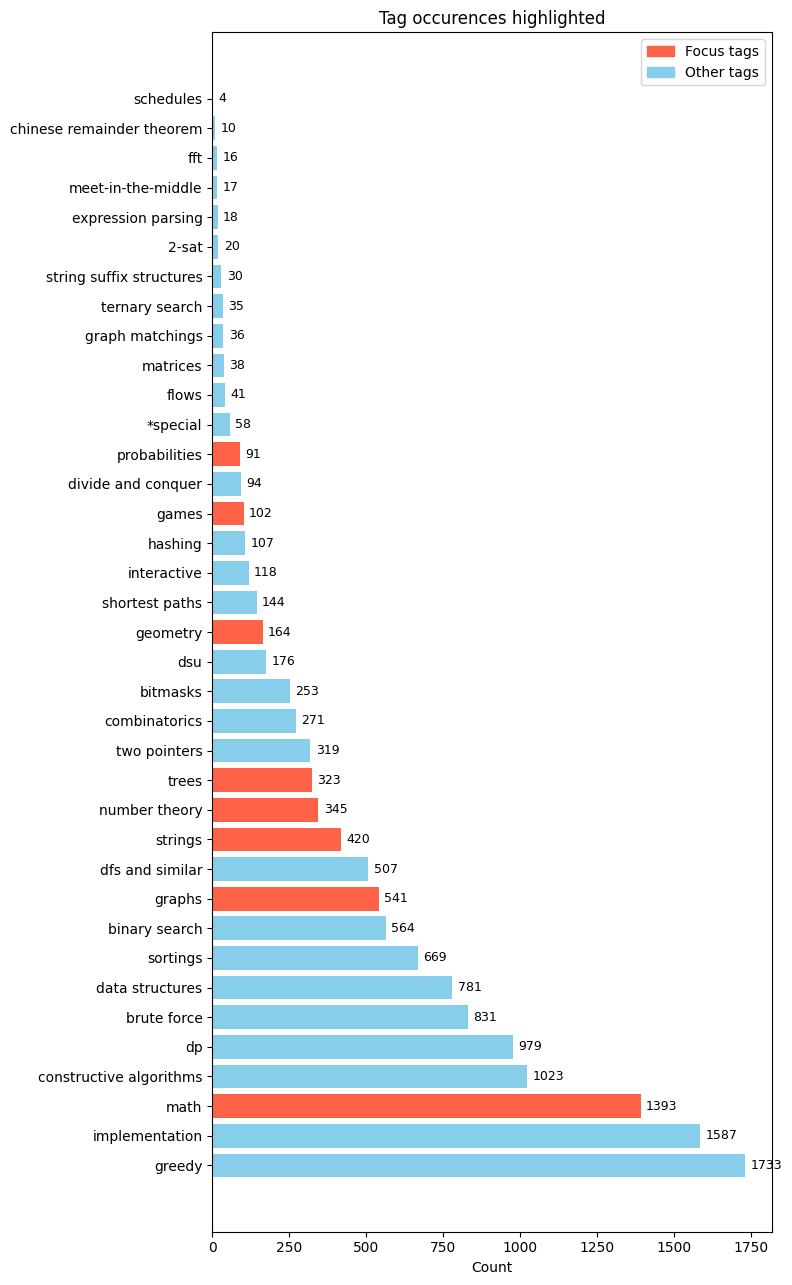

In [95]:

focus_color = 'tomato'
other_color = 'skyblue'
tags_sorted = [tag[0] for tag in tags_occ_sorted]
colors = [focus_color if tag in focus_tags else other_color for tag in tags_sorted]
counts = [tags_occ[tag] for tag in tags_sorted]

plt.figure(figsize=(8, max(4, len(tags) * 0.35)))
y = range(len(tags_sorted))
bars = plt.barh(y, counts, color=colors)
plt.yticks(y, tags_sorted)
plt.xlabel('Count')
plt.title('Tag occurences highlighted')


for bar, count in zip(bars, counts):
    width = bar.get_width()
    plt.text(width + max(1, 0.01 * max(counts)),
             bar.get_y() + bar.get_height() / 2,
             str(count),
             va='center', ha='left', fontsize=9)

plt.legend([mpatches.Patch(color=focus_color), mpatches.Patch(color=other_color)],
           ['Focus tags', 'Other tags'])

plt.tight_layout()
plt.show()

We can see that the 8 chosen classes are not the top 8 classes in the dataset,
There's still a huge disparity between the largest class (math : 1409) and the smallest (probabilities : 92)

But let's ask ourselves this question :    
 can an example be of class probabilites without being of class maths ?


In [96]:
data[data.tags.apply(lambda x: 'probabilities' in x and 'math' not in x)][['problem_description','tags']].head(5)

,problem_description,tags
282,The Bad Luck Island is inhabited by three kind...,"[dp, probabilities]"
530,Dexterina and Womandark have been arch-rivals ...,"[games, probabilities, matrices]"
831,Masha lives in a country with $$$n$$$ cities n...,"[dp, probabilities, graphs, brute force]"
854,You are given a string $$$s$$$ consisting of $...,"[brute force, dp, greedy, probabilities]"
861,"One night, having had a hard day at work, Pety...","[probabilities, sortings, binary search, dfs a..."


In [97]:
data[data.tags.apply(lambda x: 'probabilities' in x and 'math' not in x)][['problem_description','tags']].shape

(46, 2)

In [98]:
tags_occ['probabilities']

91

Now we know that we have a multilabel classification problem with distinct labels. An exercice that is labeled as "probabilities" can be labeles also as "math" and can be labeled only as "probabilities". We have also an imbalanced dataset.

<br>
<br>

Lets filter the dataset based on the 8 tags

In [99]:
data.tags = data.tags.apply(lambda x: list(set(x).intersection(set(focus_tags))))

In [100]:
data.isna().sum()

,0
src_uid,0
problem_description,0
difficulty,0
source_code,0
tags,0


In [101]:
#Since tags col is a list col, we will check for empty values seperately
data[data.tags.apply(lambda x: len(x) == 0)]

,src_uid,problem_description,difficulty,source_code,tags
2,867b01e7141ef077964a8a0d4c6b762b,You are given a square grid with $$$n$$$ rows ...,1200.0,import sys\n\ninput = lambda: sys.stdin.readli...,[]
3,a32db37cb2ebe8945a4c2f32fa2d7fc8,Polycarp loves geometric progressions — he col...,2200.0,def main():\n n = int(input())\n l = tup...,[]
4,1d4aaf15e5c6fcde50515880aae74720,In this problem we consider a special type of ...,800.0,"garbage = int(input())\nz = list(map(int, inpu...",[]
5,91be5db48b44a44adff4c809ffbb8e3e,Caisa is going to have a party and he needs to...,1200.0,"n,s=map(int,raw_input().strip().split())\n\nma...",[]
6,bc937cacda9ebff9ec0b7f00f0f97508,"Sereja has an n × m rectangular table a, each ...",2200.0,#!/usr/bin/python\n\nimport sys\nfrom math imp...,[]
...,...,...,...,...,...
4970,e745f777e5676c2629f806e09f83a739,Vitaly enrolled in the course Advanced Useless...,2200.0,import os\r\nimport sys\r\nfrom io import Byte...,[]
4971,a04cfd22f90b2b87f7c5b48dfe3de873,"Consider a hallway, which can be represented a...",2400.0,import sys\r\ninput = lambda: sys.stdin.readli...,[]
4972,c9155ff3aca437eec3c4e9cf95a2d62c,All our characters have hobbies. The same is t...,2100.0,"from heapq import heappop, heappush\n\nn, k = ...",[]
4975,31c43b62784a514cfdb9ebb835e94cad,The spring is coming and it means that a lot o...,1100.0,"t, f = [int(x) for x in raw_input().split()]\n...",[]


In [102]:
data[data.tags.apply(lambda x: any(each!=each for each in x))]

,src_uid,problem_description,difficulty,source_code,tags


In [103]:
data.loc[data.tags.apply(lambda x: len(x) == 0),'tags'] = None

In [104]:
data = data.dropna()

In [105]:
data.shape, data.src_uid.nunique()

((2656, 5), 2656)

In [106]:
data

,src_uid,problem_description,difficulty,source_code,tags
0,9a5bd9f937da55c3d26d5ecde6e50280,"Ayrat has number n, represented as it's prime ...",2000.0,from collections import Counter\nfrom operator...,"[number theory, math]"
1,8ce1ba0a98031c1bc28f53c11905391c,Petya loves lucky numbers. Everybody knows tha...,1500.0,"# 447 or 477 start with odd\n\n\nn, k = map(in...",[strings]
7,16d4035b138137bbad247ccd5e560051,One day Polycarp published a funny picture in ...,1200.0,from collections import defaultdict\n\nn=int(i...,"[graphs, trees]"
8,d3b9ffa76436b957ca959cf9204f9873,You've got another problem dealing with arrays...,1700.0,"n, k = map(int, input().split())\na = sorted(m...",[math]
10,6f0d3a7971ffc2571838ecd8bf14238d,You are given a grid with $$$n$$$ rows and $$$...,800.0,test = int(input())\r\nsteps = 0\r\nans = []\r...,[math]
...,...,...,...,...,...
4976,f26a979dc042ec9564cfecce29e5a1cf,"Egor is a famous Russian singer, rapper, actor...",2500.0,import sys\ninput = sys.stdin.readline\nfrom c...,[graphs]
4978,816a82bee65cf79ba8e4d61babcd0301,You are given a tuple generator $$$f^{(k)} = (...,2900.0,import sys\nimport time\nmod=1000000007\ndef s...,[number theory]
4979,b963c125f333eef3ffc885b59e6162c2,Vasya's got a birthday coming up and his mom d...,2100.0,"n, k = map(int, input().split())\nt = set(map(...",[number theory]
4980,18cf79b50d0a389e6c3afd5d2f6bd9ed,Bandits appeared in the city! One of them is t...,1900.0,"n = int(input())\np = list(map(int, input().sp...","[graphs, trees]"


## Modelling Approaches

In [107]:
X_data = data.drop(columns=['tags'])
y_data = data.tags
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=42)
###  Here what I usually do in in imbalanced classification problems
###  is a "stratified" train_test_split, here we have a MultiClass-Multilabel
###  classification problem, so the stratification proposed by sklearn can't handle the labels
###  What I do in this case is to use 'iterative_train_test_split' from 'skmultilearn',
###  some data transformation should be done first, for now I will not use iterative_train_test_split
###  because for the first modelling approach I'm going to use an LLM with one/few shot learning.

In [108]:
X_data

,src_uid,problem_description,difficulty,source_code
0,9a5bd9f937da55c3d26d5ecde6e50280,"Ayrat has number n, represented as it's prime ...",2000.0,from collections import Counter\nfrom operator...
1,8ce1ba0a98031c1bc28f53c11905391c,Petya loves lucky numbers. Everybody knows tha...,1500.0,"# 447 or 477 start with odd\n\n\nn, k = map(in..."
7,16d4035b138137bbad247ccd5e560051,One day Polycarp published a funny picture in ...,1200.0,from collections import defaultdict\n\nn=int(i...
8,d3b9ffa76436b957ca959cf9204f9873,You've got another problem dealing with arrays...,1700.0,"n, k = map(int, input().split())\na = sorted(m..."
10,6f0d3a7971ffc2571838ecd8bf14238d,You are given a grid with $$$n$$$ rows and $$$...,800.0,test = int(input())\r\nsteps = 0\r\nans = []\r...
...,...,...,...,...
4976,f26a979dc042ec9564cfecce29e5a1cf,"Egor is a famous Russian singer, rapper, actor...",2500.0,import sys\ninput = sys.stdin.readline\nfrom c...
4978,816a82bee65cf79ba8e4d61babcd0301,You are given a tuple generator $$$f^{(k)} = (...,2900.0,import sys\nimport time\nmod=1000000007\ndef s...
4979,b963c125f333eef3ffc885b59e6162c2,Vasya's got a birthday coming up and his mom d...,2100.0,"n, k = map(int, input().split())\nt = set(map(..."
4980,18cf79b50d0a389e6c3afd5d2f6bd9ed,Bandits appeared in the city! One of them is t...,1900.0,"n = int(input())\np = list(map(int, input().sp..."


### 1st Approach : LLM in one shot.

In [109]:
#lets test if our api is functional
client = AzureOpenAI()
response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": "You are a JSON-only response generator."},
                    {"role": "user", "content": "yoo"}
                ],
                response_format={"type": "json_object"},
            )
print(response.choices[0].message.content)

{
  "response": "Hello! How can I assist you today?"
}


The modelling (or the training) part here, is simply to iterate through prompts until finding the best prompt, for this we will use some examples of the training set, once we have the best prompt we will scale and test it on the test set.

In [186]:
## 1st iteration

SYSTEM_PROMPT = """
You are an AI assisstant that labels CODEFORCES.
"""

USER_PROMPT_1 = """
Based on a PROBLEM_DESCRIPTION of a Codeforces exercies and its respective SOURCE_CODE solution,
You will label the problem by suggesting relevant tags.
The suggested tags have to be drawn from this list : ['math', 'graphs', 'strings', 'number theory', 'trees', 'geometry', 'games', 'probabilities']
Don't create any other tags.

You need to understand the problem, the solution, the meaning of each tag and only output the best tag or tags that match the problem.
Output a json list of tags separated by commas.

PROBLEM_DESCRIPTION : {problem_description}
SOURCE_CODE : {source_code}

"""

## 2nd iteration

USER_PROMPT_2 = """
Based on a PROBLEM_DESCRIPTION of a Codeforces exercies and its respective SOURCE_CODE solution,
You will label the problem by suggesting relevant tags.
The suggested tags have to be drawn from this list : ['math', 'graphs', 'strings', 'number theory', 'trees', 'geometry', 'games', 'probabilities']
No other tags are allowed.


You need to understand the problem, the solution, the meaning of each tag and only output the best tag or tags that match the problem.
Output a json list of tags separated by commas.

Here are short, concise, precise descriptions for each Codeforces problem tag :
math — Problems that require arithmetic, algebra, combinatorics, or general mathematical reasoning and formulas (proofs, computations, identities, constructive math).
graphs — Problems about vertices and edges: traversals, shortest/longest paths, connectivity, components, cycles, flows, matchings, and graph algorithms/representations.
strings — Problems that focus on sequences of characters: pattern matching, hashing, substring/suffix structures, automata, parsing, and string transformations.
number theory — Problems about integers and their properties: primes, gcd/lcm, modular arithmetic, congruences, divisibility, totients, multiplicative functions, and modular inverses.
trees — Problems on acyclic connected graphs (rooted/unrooted): tree traversals, LCA, centroid/decomposition, rerooting, subtree queries, and tree DP.
geometry — Problems involving points, lines, polygons, distances, angles, vectors, intersections, areas, and computational geometry algorithms (convex hull, orientation, projections).
games — Problems about combinatorial games and strategies: impartial/partisan games, winning positions, Sprague–Grundy theorem, nimbers, and optimal-move analysis.
probabilities — Problems using chance and expectation: probability calculations, expected value, linearity of expectation, distributions, random processes, and probabilistic analyses.

Make sure the JSON is VALID.

Here are a few examples :
PROBLEM_DESCRIPTION : {problem_description_1}
SOURCE_CODE : {source_code_1}
TAGS : {tags_1}

PROBLEM_DESCRIPTION : {problem_description_2}
SOURCE_CODE : {source_code_2}
TAGS : {tags_2}





Label this problem :
PROBLEM_DESCRIPTION : {problem_description}
SOURCE_CODE : {source_code}

"""

**First iteration :**
llm prompt that describes the task step by step and include rules to be respected by the llm.

**Second iteration :**
 prompt that describes the task step by step, include rules to be respected by the llm but also provides some examples of problems from the training set with their respective labels.

In [130]:
def tag_with_llm(client=client, user_prompt=""):
  sleep(1)
  response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": SYSTEM_PROMPT},
                    {"role": "user", "content": user_prompt}
                ],
                response_format={"type": "json_object"},
            )
  return json.loads(response.choices[0].message.content).get('tags')

In [131]:
# The training phase here is to test the prompt with a few examples
# for speed purposes and improve the prompt each time until finding
# the best prompt (lets try with 1/15 of the train set, less than 200 examples)
X_prompt = X_train[:len(X_train)//15]
y_prompt = y_train[:len(y_train)//15]

In [132]:
X_prompt.shape , y_prompt.shape

((132, 4), (132,))

##### First prompt

In [133]:
#one example testing
tag_with_llm(user_prompt=USER_PROMPT_1.format(problem_description=X_prompt.iloc[0].problem_description, source_code=X_prompt.iloc[0].source_code))

['math']

In [134]:
y_prompt.iloc[0]

['math']

In [140]:
y_prompt_predicted = []
for i in range(X_prompt.shape[0]):
  y_prompt_predicted.append(tag_with_llm(user_prompt=USER_PROMPT_1.format(problem_description=X_prompt.iloc[i].problem_description, source_code=X_prompt.iloc[i].source_code)))

In [141]:
sum([e==None for e in y_prompt_predicted])

6

In [147]:
# Re run the model on examples that where not processed correctly by the llm
for i in range(len(y_prompt_predicted)):
  if y_prompt_predicted[i] == None:
    y_prompt_predicted[i] = tag_with_llm(user_prompt=USER_PROMPT_1.format(problem_description=X_prompt.iloc[i].problem_description, source_code=X_prompt.iloc[i].source_code))

In [148]:
sum([e==None for e in y_prompt_predicted])

0

In [149]:
### We will use 'weighted f1 score' for evaluation, in order not to penalize the model for the smaller classes
mlb = MultiLabelBinarizer()
y_prompt_encoded = mlb.fit_transform(y_prompt)
y_prompt_predicted_encoded = mlb.fit_transform(y_prompt_predicted)

weighted = f1_score(y_prompt_encoded, y_prompt_predicted_encoded, average='weighted')

In [150]:
print('First prompt f1 score :',weighted)

First prompt f1 score : 0.6890580209002773


##### Second prompt

In [151]:
#one example testing
tag_with_llm(user_prompt=USER_PROMPT_2.format(
  problem_description_1=X_prompt.iloc[-1].problem_description,
  source_code_1=X_prompt.iloc[-1].source_code,
  tags_1=y_prompt.iloc[-1],

  problem_description_2=X_prompt.iloc[-2].problem_description,
  source_code_2=X_prompt.iloc[-2].source_code,
  tags_2=y_prompt.iloc[-2],

  problem_description=X_prompt.iloc[0].problem_description,
  source_code=X_prompt.iloc[0].source_code))

['math']

In [152]:
y_prompt_predicted = []
for i in range(X_prompt.shape[0]):
  y_prompt_predicted.append(tag_with_llm(user_prompt=USER_PROMPT_2.format(
        problem_description_1=X_prompt.iloc[-1].problem_description,
  source_code_1=X_prompt.iloc[-1].source_code,
  tags_1=y_prompt.iloc[-1],

  problem_description_2=X_prompt.iloc[-2].problem_description,
  source_code_2=X_prompt.iloc[-2].source_code,
  tags_2=y_prompt.iloc[-2],


      problem_description=X_prompt.iloc[i].problem_description, source_code=X_prompt.iloc[i].source_code)))

while sum([e==None for e in y_prompt_predicted])>0:
  for i in range(len(y_prompt_predicted)):
    if not y_prompt_predicted[i]:
      y_prompt_predicted[i] = tag_with_llm(user_prompt=USER_PROMPT_2.format(
          problem_description_1=X_prompt.iloc[-1].problem_description,
    source_code_1=X_prompt.iloc[-1].source_code,
    tags_1=y_prompt.iloc[-1],

    problem_description_2=X_prompt.iloc[-2].problem_description,
    source_code_2=X_prompt.iloc[-2].source_code,
    tags_2=y_prompt.iloc[-2],


        problem_description=X_prompt.iloc[i].problem_description, source_code=X_prompt.iloc[i].source_code))

In [153]:
mlb = MultiLabelBinarizer()
y_prompt_encoded = mlb.fit_transform(y_prompt)
y_prompt_predicted_encoded = mlb.fit_transform(y_prompt_predicted)

weighted = f1_score(y_prompt_encoded, y_prompt_predicted_encoded, average='weighted')

In [154]:
print('Second prompt f1 score :',weighted)

Second prompt f1 score : 0.6955657774072096


In [155]:
print(classification_report(y_prompt_encoded, y_prompt_predicted_encoded))

              precision    recall  f1-score   support

           0       0.30      0.75      0.43         4
           1       0.71      0.83      0.77        12
           2       0.84      0.59      0.70        27
           3       0.78      0.58      0.67        65
           4       0.60      0.60      0.60        15
           5       0.75      0.60      0.67         5
           6       0.81      0.81      0.81        26
           7       0.91      0.62      0.74        16

   micro avg       0.74      0.65      0.69       170
   macro avg       0.71      0.67      0.67       170
weighted avg       0.77      0.65      0.70       170
 samples avg       0.76      0.69      0.70       170



We see a small improvement in the f1 score,
We choose the second prompt as our model, and we will run it through the test set to evaluate its performance

In [187]:
### RUN ON TEST SET

y_prompt_predicted = []
for i in range(X_test.shape[0]):
  y_prompt_predicted.append(tag_with_llm(user_prompt=USER_PROMPT_2.format(
        problem_description_1=X_prompt.iloc[-1].problem_description,
  source_code_1=X_prompt.iloc[-1].source_code,
  tags_1=y_prompt.iloc[-1],

  problem_description_2=X_prompt.iloc[-2].problem_description,
  source_code_2=X_prompt.iloc[-2].source_code,
  tags_2=y_prompt.iloc[-2],


      problem_description=X_test.iloc[i].problem_description, source_code=X_test.iloc[i].source_code)))

while sum([e==None for e in y_prompt_predicted])>0:
  for i in range(len(y_prompt_predicted)):
    if y_prompt_predicted[i] == None:
      y_prompt_predicted[i] = tag_with_llm(user_prompt=USER_PROMPT_2.format(
          problem_description_1=X_prompt.iloc[-1].problem_description,
    source_code_1=X_prompt.iloc[-1].source_code,
    tags_1=y_prompt.iloc[-1],

    problem_description_2=X_prompt.iloc[-2].problem_description,
    source_code_2=X_prompt.iloc[-2].source_code,
    tags_2=y_prompt.iloc[-2],


    problem_description=X_test.iloc[i].problem_description, source_code=X_test.iloc[i].source_code)
      )

In [188]:
mlb = MultiLabelBinarizer()
y_prompt_encoded = mlb.fit_transform(y_test)
y_prompt_predicted_encoded = mlb.fit_transform(y_prompt_predicted)

weighted = f1_score(y_prompt_encoded, y_prompt_predicted_encoded, average='weighted')

In [189]:
print('F1 Score on test set: ',weighted)

F1 Score on test set:  0.711880222655802


In [190]:
print(classification_report(y_prompt_encoded, y_prompt_predicted_encoded))

              precision    recall  f1-score   support

           0       0.31      1.00      0.47        19
           1       0.63      0.88      0.73        33
           2       0.88      0.62      0.73       156
           3       0.82      0.56      0.67       323
           4       0.62      0.74      0.67        86
           5       0.80      0.70      0.74        23
           6       0.75      0.86      0.80       107
           7       0.88      0.74      0.80        85

   micro avg       0.74      0.68      0.71       832
   macro avg       0.71      0.76      0.70       832
weighted avg       0.79      0.68      0.71       832
 samples avg       0.77      0.72      0.72       832



### 2nd Approach : BERT Classifier

In [160]:
labels_to_ids = {j:i for i,j in enumerate(focus_tags)}
ids_to_labels = {i:j for i,j in enumerate(focus_tags)}

In [161]:
labels_to_ids

{'math': 0,
 'graphs': 1,
 'strings': 2,
 'number theory': 3,
 'trees': 4,
 'geometry': 5,
 'games': 6,
 'probabilities': 7}

In [162]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 2
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [163]:
# Data retriever class, we need to tokenize text and binerize labels
# before feeding the Bert classifier, this class will help us handle
# this part on the fly

class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):

        sentence = self.data.problem_description[index].strip()
        labels = self.data.tags[index]

        encoding = self.tokenizer(sentence,
                             return_offsets_mapping=True,
                             padding='max_length',
                             truncation=True,
                             max_length=self.max_len)

        labels_holder = np.array([0 for _ in range(len(labels_to_ids))], dtype=np.float32)
        for label in labels:
          labels_holder[labels_to_ids[label]] = 1
        labels = labels_holder[:]

        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(labels)
        return item

    def __len__(self):
        return self.len

In [164]:
# We create an architecture based on a bert model for the embedding phase
# We add a dense layer for classification (we could have added a droupout layer in between)

class ModelClassifier(pl.LightningModule):

  def __init__(self, n_classes: int, model_name: str):
    super().__init__()
    self.bert = BertModel.from_pretrained(model_name, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss


  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(params=self.parameters(), lr=LEARNING_RATE)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=20,
      num_training_steps=100
    )
    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [165]:
train_dataset = data[data.index.isin(X_train.index)]
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (2656, 5)
TRAIN Dataset: (1992, 5)
TEST Dataset: (664, 5)


In [166]:

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [167]:
model = ModelClassifier(len(labels_to_ids),'bert-base-uncased')
#trainer = pl.Trainer(accelerator="cpu", devices=1, max_epochs=3)
#trainer.fit(model, training_loader)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [168]:
model = ModelClassifier(len(labels_to_ids),'bert-base-uncased')
state_dict = torch.load("model_v1",  weights_only=True, map_location=device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [180]:
THRESHOLD = 0.5
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
  for idx, batch in enumerate(testing_loader):

    ids = batch['input_ids']
    mask = batch['attention_mask']
    labels = batch['labels']

    loss, predictions = model(input_ids=ids, attention_mask=mask, labels=labels)
    predictions = (predictions > THRESHOLD).long()

    y_pred.append(predictions)
    y_true.append(labels)


In [181]:

metric = MulticlassF1Score(num_classes=len(labels_to_ids), average="weighted")
f1_tensor = metric(predictions, labels)

f1_value = f1_tensor.item() if isinstance(f1_tensor, torch.Tensor) else float(f1_tensor)
print("Weighted multiclass F1:", f1_value)

Weighted multiclass F1: 0.9281609058380127


The bert based model clearly outperforms the one shot LLM approach. This is not surprising since the BERT is trained but the LLM was not.

We will use the bert model for the cli module.

In [183]:
!python problem_tagger.py --test true

2025-10-28 15:34:06.603398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761665646.628375   41830 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761665646.635450   41830 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761665646.653355   41830 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761665646.653402   41830 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761665646.653407   41830 computation_placer.cc:177] computation placer alr

### Improvements

This work was done in 4h approximatively. If more time is to be invested in the project we can explore many approaches/techniques that could improve performance.

<br>

##### DATASET improvements :
- We have an imbalanced dataset, that's the first thing to be approached.
Historically techniques that uses synthetic data augmentation (like SMOTE) are the first thing to be tested. But here we are lucky enough to have a real world dataset publically available. So what we can do is simply augment the very small classes with real world codeforces problems. ATTENTION : This does not mean creating a dataset with all classes equally presented, because that's not what the real world is (real world : codeforces problems dataset). So we will try to have a balance between minimum necessary number of samples for the model to learn and real world disparity between labels.

- Lemming/Stemming techniques, usually we need to do some preprocessing before dealing with textual data. In generator LLMs like GPT and even in embedding LLMs like BERT, this is not a crucial part because models were pretrained on huge enough datasets and can deal with raw text (only required part is tokenization). But this part can be useful if we will try later a small ML model

<br>

##### MODELLING improvements :    
- The generative LLM part was not as good as the Bert classifier, because the model was used in oneshot. Trying approaches like Finetuning (QLORA) with open source LLMs can be promising.
- Using a small ML model as a first benchmark can help us figure out the performance/complexity tradeoff, its always better to start with simple techniques before trying more complicated deep learning approaches

